# Lending Club Case Study

## Table of Contents
1. [Business Use Case](#business-use-case)
2. [Data Sourcing](#data-sourcing)
3. [Data Cleaning](#data-cleaning)
4. [Data Manipulation](#data-manipulation)
5. [Data Visualization](#data-visualization)\
    5.1. [Univariate Analysis](#univariate-analysis)\
    5.2. [Bivariate Analysis](#bivariate-analysis)\
    5.3. Observations
6. [Derived Metrics](#derived-metrics)\
    6.1. Observations

# Business Use Case

Consumer Finance Company (CFC) specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Borrowers who default cause the largest amount of loss to the lenders. One has to identify these risky loan applications, then such loans can be reduced by cutting down the credit loss. The company wants to understand the driving factors behind the loan default.

# Data Sourcing

Data Sourcing from Loan Dataset - https://github.com/GopalS1208/LendingClubCaseStudy/blob/main/lcc_loan.csv \
Data Dictionary - https://github.com/GopalS1208/LendingClubCaseStudy/blob/main/Data_Dictionary.xlsx

## Data Cleaning

### Importing All the Required Modules

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings

loan_df = pd.read_csv("lcc_loan.csv", low_memory=False)
loan_df.shape

(39717, 111)

### Fixing Columns 

1. Original Dataset had Rows * Columns - 39717 * 111.
2. Dropping the columns with all the rows as NULL (54 columns contain all rows as NULL, hence deleting).
3. Dropping the rows with Loan Status='Current' as they cannot be used for analysis.
4. Dropping the columns which has Single value throughout the sample dataset which cannot be used for analysis.
5. Dropping the columns which are having more unique values(38577 unique)
6. Again dropping the columns if any with all the rows as NULL (After removing the columns of the previous steps).

In [34]:
loan_df = loan_df.loc[:,loan_df.isnull().sum()!=len(loan_df.index)]
loan_df = loan_df.loc[loan_df['loan_status']!='Current']
loan_df = loan_df.loc[:,loan_df.nunique()!=1]
loan_df = loan_df.loc[:,loan_df.nunique()!=len(loan_df.index)]
loan_df = loan_df.loc[:,loan_df.isnull().sum()!=len(loan_df.index)]
loan_df.shape

(38577, 42)

7. Removing columns, details which are given by borrower which cannot be used for analysis.
    - emp_title - Although emp title can be used, but this contains data not suitable for analysis
    - desc
    - zip_code
    - addr_state

In [35]:
borrower_details_columns_list=['emp_title','desc','zip_code','addr_state']
loan_df=loan_df.drop(borrower_details_columns_list,axis=1)
loan_df.shape

(38577, 38)

8. Dropping all the post approval features
    - delinq_2yrs
    - earliest_cr_line
    - inq_last_6mths
    - mths_since_last_delinq
    - mths_since_last_record
    - pub_rec
    - revol_bal
    - revol_util
    - total_acc
    - total_pymnt
    - total_pymnt_inv
    - total_rec_prncp
    - total_rec_int
    - total_rec_late_fee
    - recoveries
    - collection_recovery_fee
    - last_pymnt_d
    - last_pymnt_amnt
    - last_credit_pull_d
    - pub_rec_bankruptcies    

In [36]:
post_approval_columns_list = ['delinq_2yrs', 'earliest_cr_line','inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d','pub_rec_bankruptcies']
loan_df=loan_df.drop(post_approval_columns_list,axis=1)
loan_df.shape

(38577, 18)

9. Checking for the missing values\
Other than emp_length most of the columns has negligible NULL values

In [37]:
(loan_df.isna().sum()/len(loan_df.index))*100

loan_amnt              0.000000
funded_amnt            0.000000
funded_amnt_inv        0.000000
term                   0.000000
int_rate               0.000000
installment            0.000000
grade                  0.000000
sub_grade              0.000000
emp_length             2.677761
home_ownership         0.000000
annual_inc             0.000000
verification_status    0.000000
issue_d                0.000000
loan_status            0.000000
purpose                0.000000
title                  0.028514
dti                    0.000000
open_acc               0.000000
dtype: float64

## Data Understanding & Manipulation

1. Interest Rate of the loan, removing the "%"

In [38]:
loan_df['int_rate']=loan_df['int_rate'].apply(lambda x:x.replace('%',''))
loan_df['int_rate']=loan_df['int_rate'].astype(float)
loan_df['int_rate'].info()

<class 'pandas.core.series.Series'>
Index: 38577 entries, 0 to 39716
Series name: int_rate
Non-Null Count  Dtype  
--------------  -----  
38577 non-null  float64
dtypes: float64(1)
memory usage: 602.8 KB


2. Calculating mode of emp length column

In [39]:
loan_df.emp_length.mode()[0]
loan_df.emp_length.value_counts()

emp_length
10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: count, dtype: int64

Since Mode is 10+ years, and missing value % is 2.67 hence we can impute 10+ years value to the missing values as it might not alter the analysis much.

In [40]:
loan_df.emp_length.fillna(loan_df.emp_length.mode()[0], inplace=True)
loan_df.emp_length.value_counts()

emp_length
10+ years    9521
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: count, dtype: int64

3. Converting the emp length to integer for further analysis

In [41]:
loan_df['emp_length']=loan_df['emp_length'].apply(lambda x:x.split(' ')[0])
loan_df['emp_length']=loan_df['emp_length'].replace({'<': 0, '10+': 10, })
loan_df['emp_length']=loan_df['emp_length'].astype('int32')
loan_df.emp_length.value_counts()

emp_length
10    9521
0     4508
2     4291
3     4012
4     3342
5     3194
1     3169
6     2168
7     1711
8     1435
9     1226
Name: count, dtype: int64

4. Issue Date is split to Month & Year for analysis

In [42]:
loan_df['issue_year']=pd.to_datetime(loan_df['issue_d'], format='%b-%y').dt.strftime('%Y')
loan_df['issue_month']=pd.to_datetime(loan_df['issue_d'], format='%b-%y').dt.strftime('%m')
loan_df['issue_month']=pd.to_datetime(loan_df['issue_month'], format='%m').dt.month_name().str.slice(stop=3)
loan_df.shape

(38577, 20)

5. Calculating the Funded Amount Difference for Analysis

In [43]:
loan_df['Funded_Amt_Difference']=loan_df['funded_amnt']-loan_df['funded_amnt_inv']
loan_df['Funded_Amt_Difference']=round(loan_df['Funded_Amt_Difference'],2)
loan_df['Funded_Amt_Difference'].value_counts()

Funded_Amt_Difference
0.00       19347
25.00       3737
50.00       1662
250.00      1210
100.00       721
           ...  
191.73         1
167.48         1
112.64         1
56.14          1
4475.00        1
Name: count, Length: 6709, dtype: int64

Checking the Final Shape & Getting the Final List of Columns

In [44]:
print("Final Shape of the dataset: ", loan_df.shape)
print("Final List of Columns: ", loan_df.columns)

Final Shape of the dataset:  (38577, 21)
Final List of Columns:  Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'dti', 'open_acc', 'issue_year', 'issue_month',
       'Funded_Amt_Difference'],
      dtype='object')


# Data Visualization

Univariate Analysis
1. Emp Length 
Plotting Histogram to find the distribution of Employee Length in Service.
    - 10 years employees are the more frequent customers applying loan 

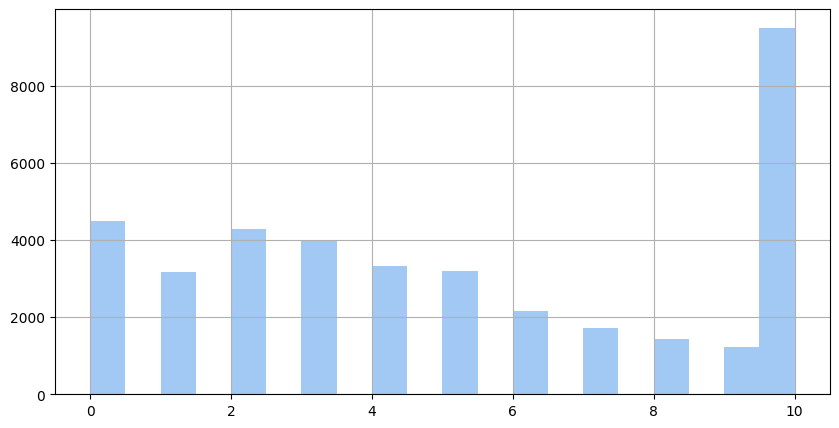

In [45]:
plt.figure(figsize=(10,5))
loan_df['emp_length'].hist(bins=20)
plt.show()

2. Home Ownership - Plotting Histogram to find the distribution of Home Ownership in Service.

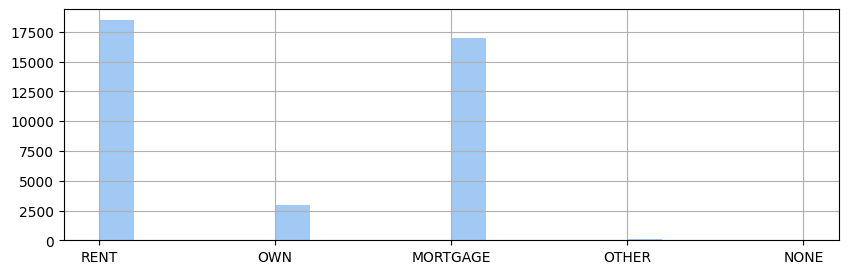

In [46]:
plt.figure(figsize=(10,3))
loan_df['home_ownership'].hist(bins=20)
plt.show()

3. Analyzing Purpose of Loan

In [47]:
loan_df['purpose'].unique()
loan_df['purpose'].value_counts()

purpose
debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: count, dtype: int64

Observation :- As we can see "Debt consolition, credit card" are the major drivers for applying for Loan

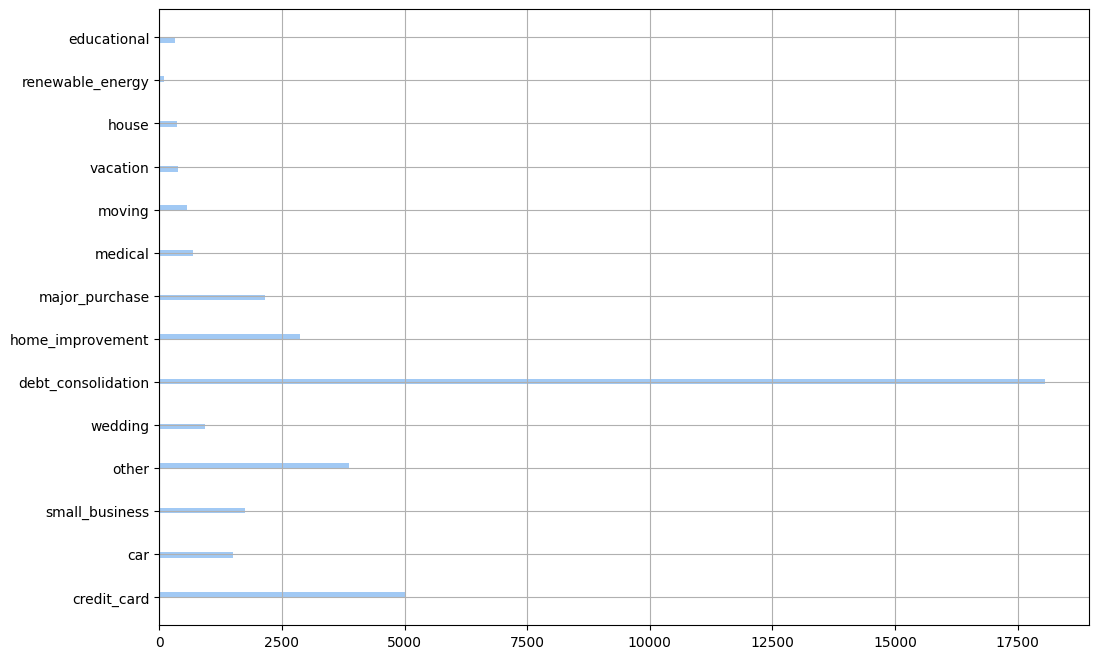

In [48]:
plt.figure(figsize = (12,8))
loan_df['purpose'].hist(bins=100,orientation='horizontal')
plt.show()

4. Annual Income, it varies from 25 percentile - 40000 to 75 percentile - 82000. Clearly Outliers seems to be present for more than 95 percentile. So we are removing the data more than 95 percentile.

In [49]:
loan_df['annual_inc']=loan_df['annual_inc'].astype(int)
loan_df['annual_inc'].quantile([0.1, 0.2, 0.25, 0.5, 0.75,0.90, 0.95, 0.97,0.98, 0.99])
percent_95_annual_inc=loan_df['annual_inc'].quantile(0.95)
loan_df=loan_df[loan_df['annual_inc']<percent_95_annual_inc]
loan_df.shape

(36642, 21)

In [84]:
loan_df['annual_inc'].describe()

count     36642.000000
mean      60829.824491
std       27717.832573
min        4000.000000
25%       40000.000000
50%       56000.000000
75%       77703.750000
max      140000.000000
Name: annual_inc, dtype: float64

In [85]:
loan_df['dti'].describe()

count    36642.000000
mean        13.447256
std          6.661561
min          0.000000
25%          8.350000
50%         13.580000
75%         18.717500
max         29.990000
Name: dti, dtype: float64

Idenfying Outliers of "Annual Income" & "DTI"\
    Some Outliers are there for Annual Income, but they are more than 95 percentile, since they are negligible leaving them untouched.

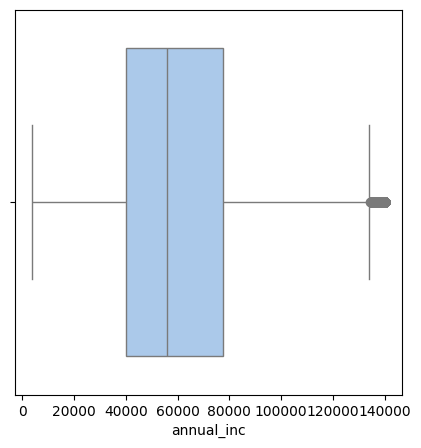

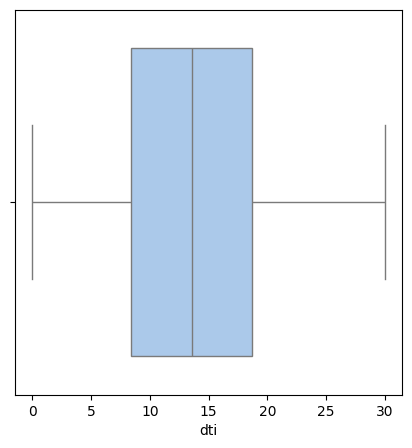

In [50]:
plt.figure(figsize = (5,5))
sns.boxplot(loan_df['annual_inc'], orient='h')
plt.figure(figsize = (5,5))
sns.boxplot(loan_df['dti'], orient='h')
plt.show()

5. Grade is compared with their counts.

<Axes: xlabel='grade', ylabel='count'>

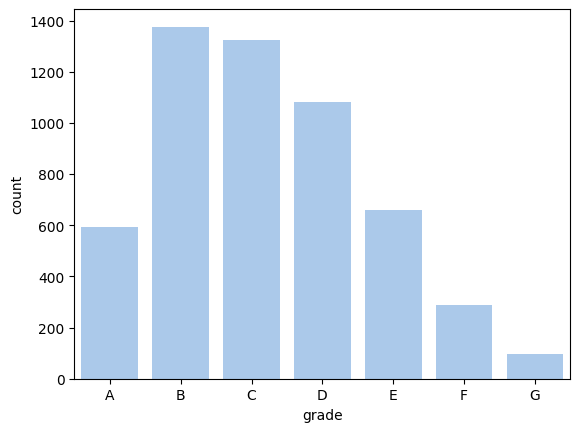

In [51]:
sns.countplot(x = 'grade', data = loan_df[loan_df.loan_status == 'Charged Off'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])

Then visualizing Sub Grade with their counts. Since each Grade has 5 Sub grades in it, updating the subgrade column with only the numeric digit & combination of Grade & Subgrade column then visualized for their Counts.

In [52]:
loan_df.sub_grade = pd.to_numeric(loan_df.sub_grade.apply(lambda x : x[-1]))
loan_df.sub_grade.head()

0    2
1    4
2    5
3    1
5    4
Name: sub_grade, dtype: int64

<Axes: xlabel='Grade_Order', ylabel='Count'>

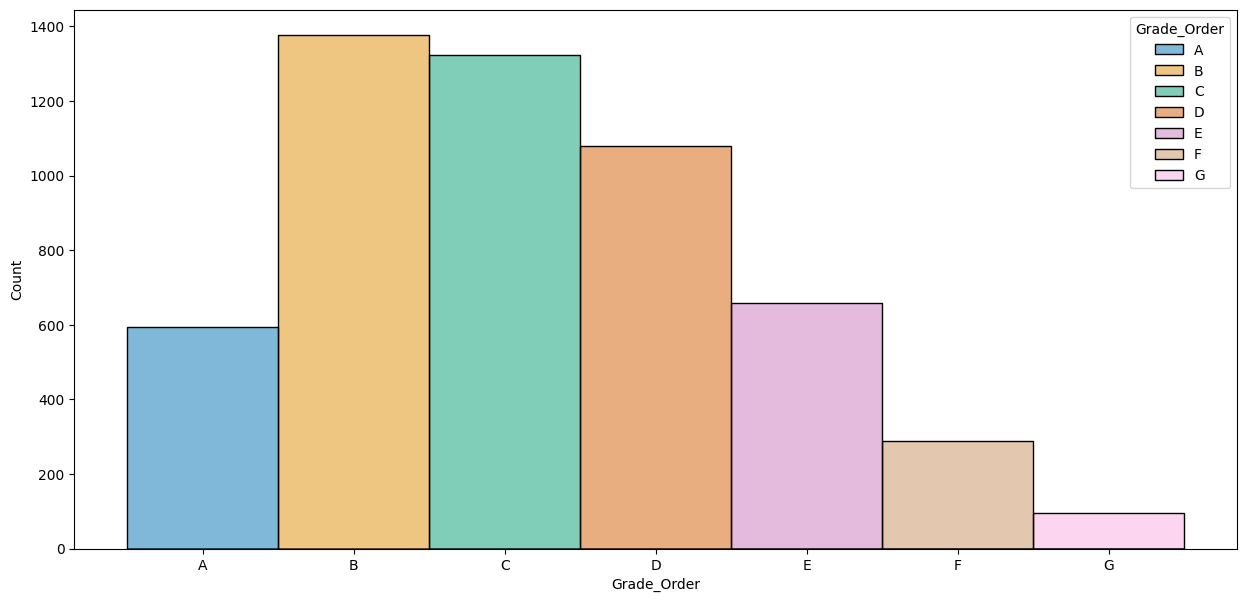

In [59]:
fig, ax = plt.subplots(figsize=(15,7))
sns.set_palette("colorblind",8)
loan_df['Grade_Order']=pd.Categorical(loan_df['grade'], ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
sns.histplot(x = 'Grade_Order', hue = 'Grade_Order',data = loan_df[loan_df.loan_status == 'Charged Off'])

<Axes: xlabel='grade', ylabel='count'>

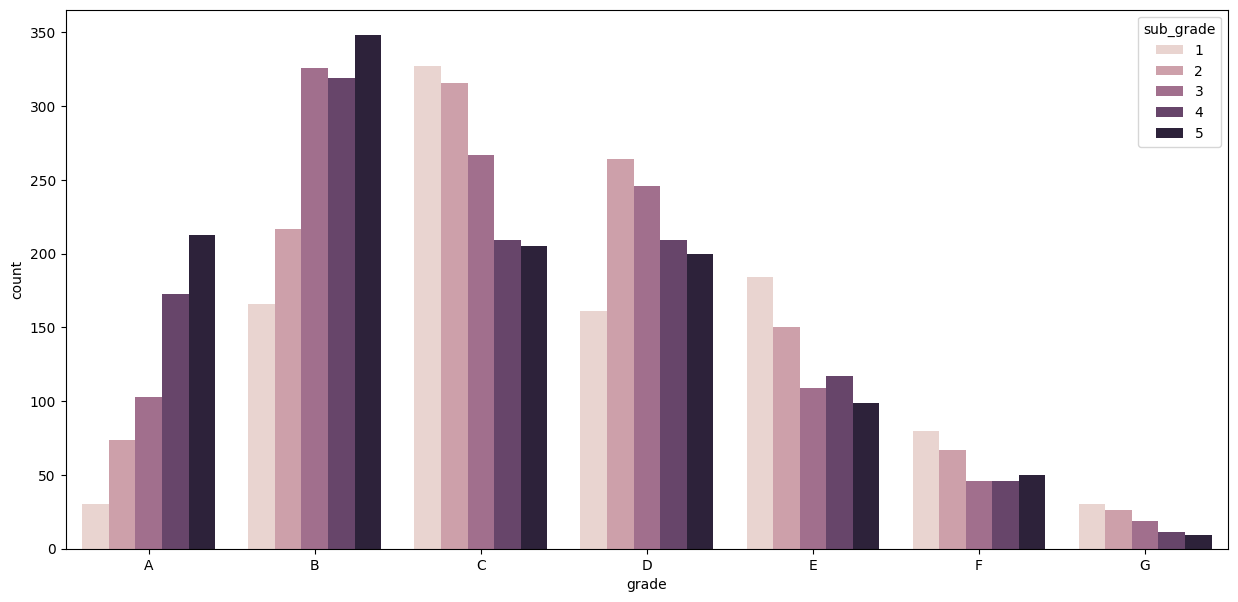

In [64]:
loan_df.drop(['Grade_Order'],axis=1)
fig, ax = plt.subplots(figsize=(15,7))
sns.set_palette("colorblind",8)
sns.countplot(x = 'grade', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'] , hue = 'sub_grade',data = loan_df[loan_df.loan_status == 'Charged Off'])

As shown, Grade B has maximum exposure to Loans which are "Charged Off" - means defaulted & in Grade B mainly Sub Grade 5

6. Plotting number of loans disbursed with respect to Issue Month & Issue Year

<Axes: xlabel='issue_year', ylabel='Count'>

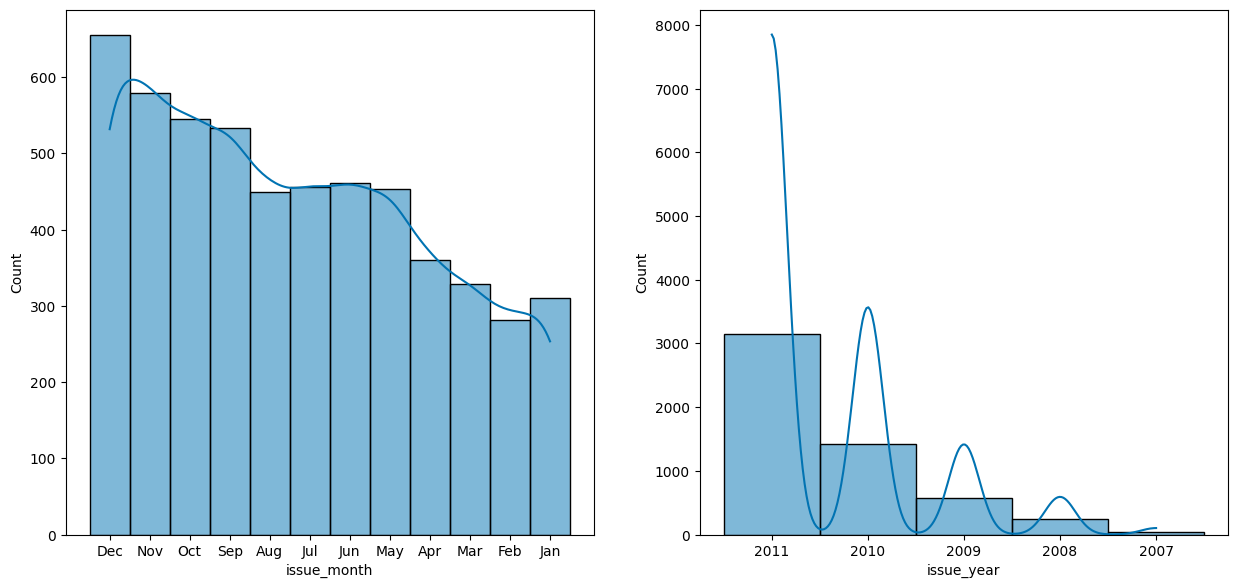

In [70]:
plt.figure(figsize=(15,15))
plt.subplot(221)
sns.histplot(x='issue_month', data=loan_df[loan_df['loan_status']=='Charged Off'],kde=True)
plt.subplot(222)
sns.histplot(x='issue_year', data=loan_df[loan_df['loan_status']=='Charged Off'],kde=True)

As shown the Disbursement is highest in Dec decreases till Jan. \
    - Only exception is Feb but can be interpreted as Feb has less no of days than Jan.\
And in case of Issue Year, the disbursements are more in 2011 and it has increased from 2007-2011, possible could be due to Sub-prime crisis & its after effects.

7. Plotting Funded Amount Difference vs Loan Status to check if the Funded Amount Difference impacts the ability of the consumer to payback loan

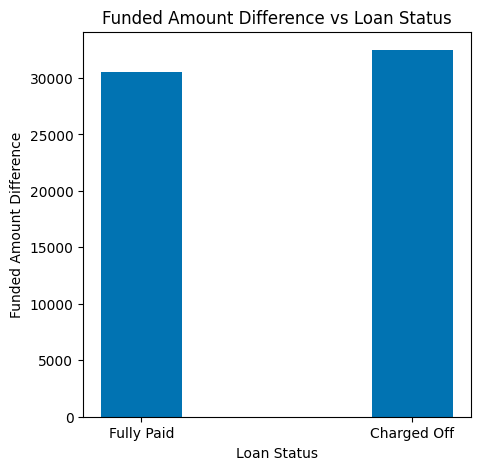

In [71]:
fig,ax = plt.subplots(figsize=(5,5))
ax.bar(loan_df['loan_status'], loan_df['Funded_Amt_Difference'], width=0.3)
ax.set_ylabel('Funded Amount Difference')
ax.set_xlabel('Loan Status')
ax.set_title('Funded Amount Difference vs Loan Status')
plt.show()

8. Finally getting the columns

In [76]:
loan_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'dti', 'open_acc', 'issue_year', 'issue_month',
       'Funded_Amt_Difference', 'Grade_Order'],
      dtype='object')

In [81]:
loan_df['installment'].to_csv("installment.csv")

# Derived Metrics

1. Creating more columns as Bins for some numerical variable to make them categorical

In [82]:
loan_df['int_rate_groups'] = pd.cut(loan_df['int_rate'], bins=5,precision =0,labels=['5%-9%','9%-13%','13%-17%','17%-21%','21%-24%'])
loan_df['annual_inc_groups'] = pd.cut(loan_df['annual_inc'], bins=5,precision =0,labels =['3k-31k','31k-58k','58k-85k','85k-112k','112k-140k'])
loan_df['installment_groups'] = pd.cut(loan_df['installment'], bins=10,precision =0,labels=['14-145','145-274','274-403','403-531','531-660','660-789','789-918','918-1047','1047-1176','1176-1305'])
loan_df['funded_amnt_inv_group'] = pd.cut(loan_df['funded_amnt_inv'], bins=7,labels=['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k'])
loan_df['loan_amnt_groups'] = pd.cut(loan_df['loan_amnt'], bins=7,precision =0,labels=['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k'])
loan_df['dti_groups'] = pd.cut(loan_df['dti'], bins=5,precision =0,labels=['0-6','6-12','12-18','18-24','24-30'])

2. Analysing Interest Rates with the Bins created

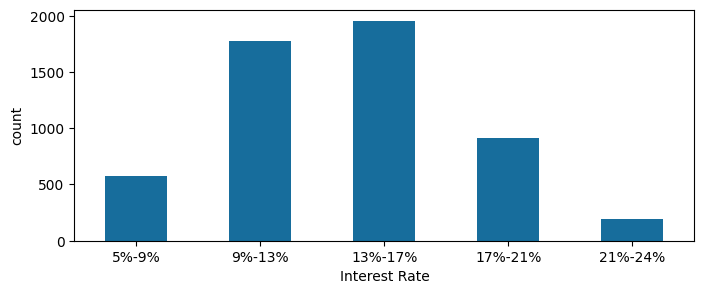

Text(0.5, 0, 'Annual Income')

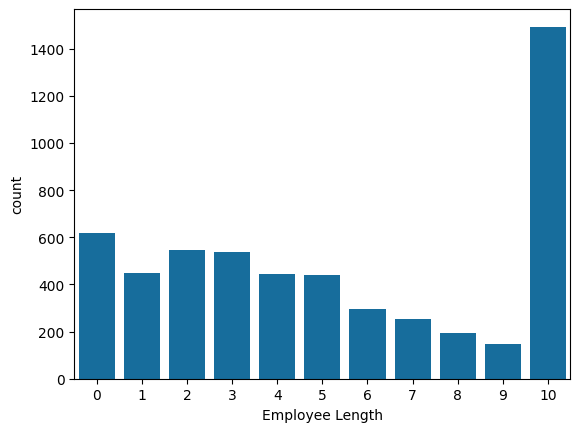

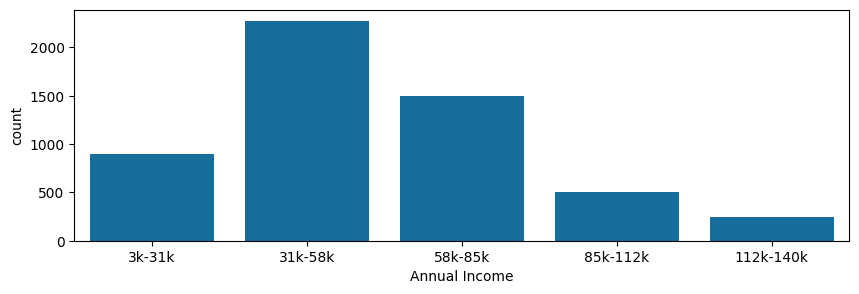

In [83]:
fig, ax = plt.subplots(figsize = (8,3))
sns.countplot(x='int_rate_groups', data=loan_df[loan_df.loan_status == 'Charged Off'], width=0.5)
plt.xlabel('Interest Rate')
plt.show()
sns.countplot(x='emp_length', data=loan_df[loan_df.loan_status == 'Charged Off'])
plt.xlabel('Employee Length')
fig, ax = plt.subplots(figsize = (10,3))
sns.countplot(x='annual_inc_groups', data=loan_df[loan_df.loan_status == 'Charged Off'])
plt.xlabel('Annual Income')

<Axes: xlabel='funded_amnt_inv_group', ylabel='count'>

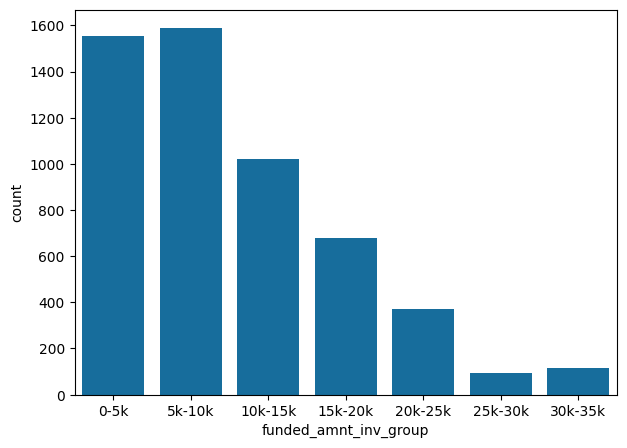

In [86]:
fig,ax = plt.subplots(figsize = (7,5))
sns.countplot(x='funded_amnt_inv_group', data=loan_df[loan_df['loan_status']=='Charged Off'])

<Axes: xlabel='loan_amnt_groups', ylabel='count'>

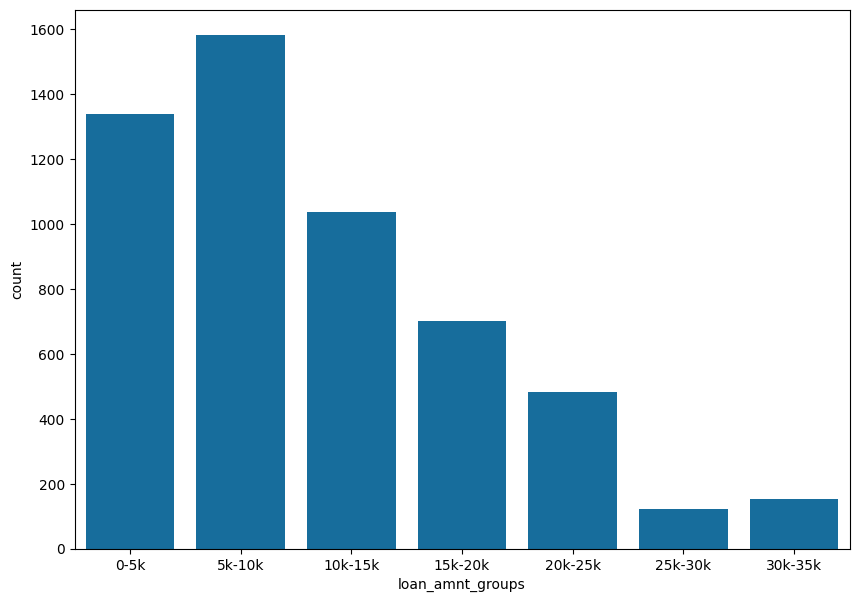

In [87]:
fig,ax = plt.subplots(figsize = (10,7))
sns.countplot(x='loan_amnt_groups', data=loan_df[loan_df['loan_status']=='Charged Off'])

<Axes: xlabel='dti_groups', ylabel='count'>

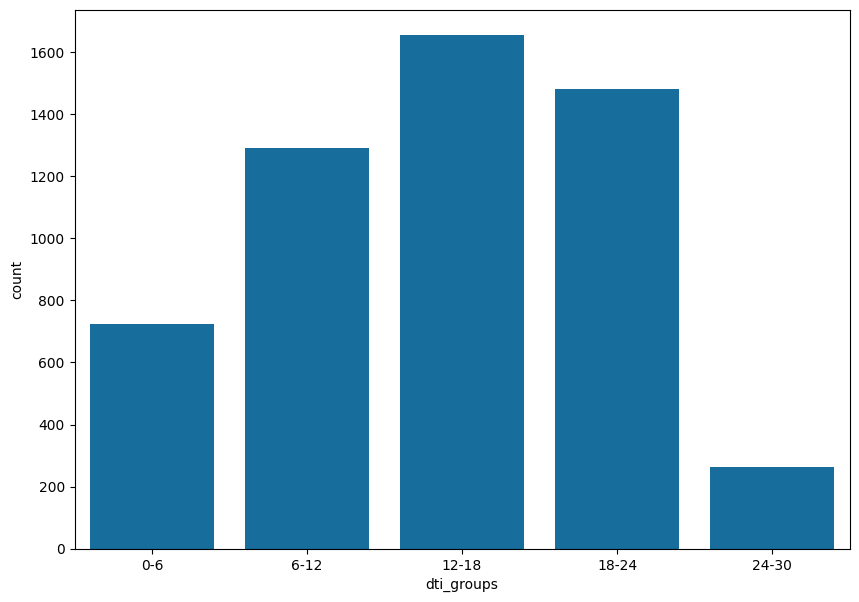

In [88]:
fig,ax = plt.subplots(figsize = (10,7))
sns.countplot(x='dti_groups', data=loan_df[loan_df['loan_status']=='Charged Off'])

<Axes: xlabel='installment_groups', ylabel='count'>

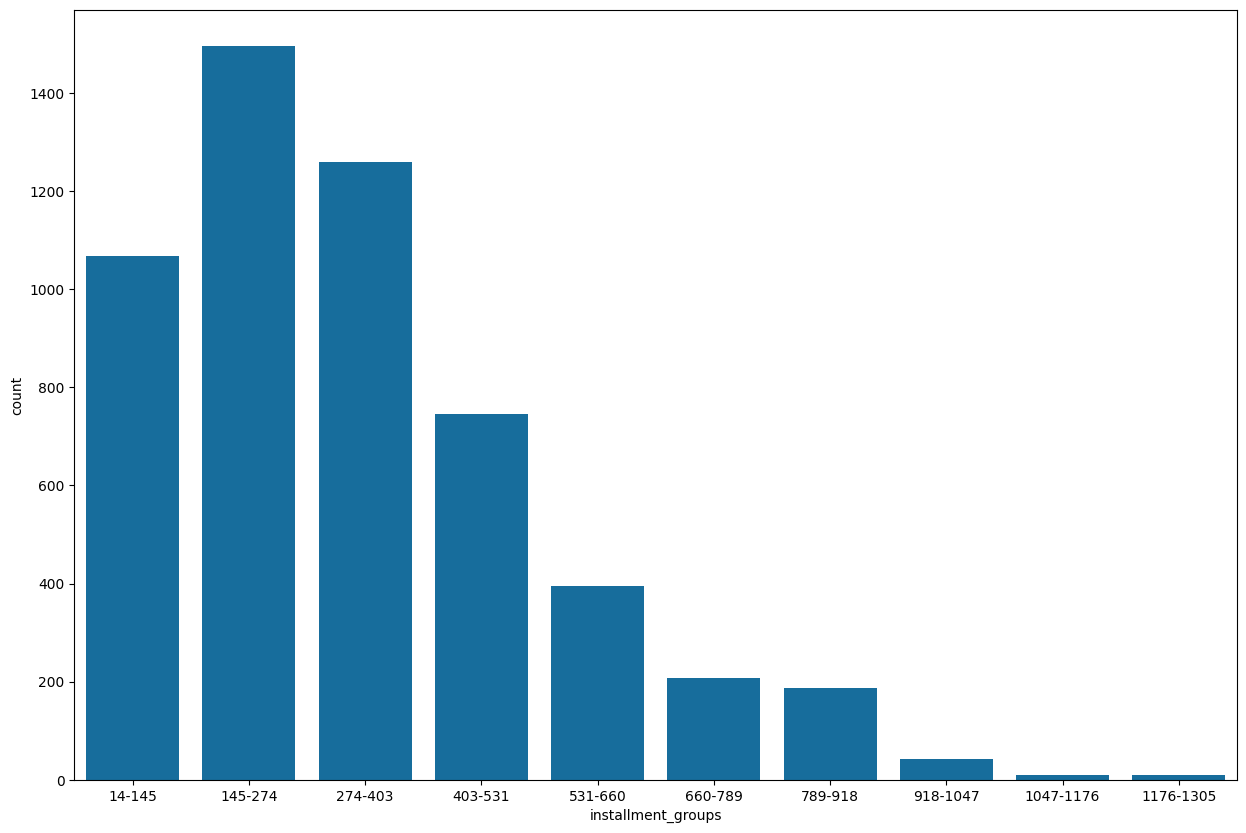

In [89]:
fig,ax = plt.subplots(figsize = (15,10))
sns.countplot(x='installment_groups', data=loan_df[loan_df['loan_status']=='Charged Off'])

## Observations

### The above analysis with respect to "Charged-OFF" loans for each variable suggests the following. There is a more probability of defaulting when: 

- Applicants who are purchasing loans by being in "RENT" house.
- Applicants who are having employment length period of >=10 years(Basically 10+ years, remember that we have imputed all the 10+ years as 10 years).
- Applicants who take loan to consolidate & clear off Other Loans (Debt Consolidation, & then Credit Card).
- Applicants who have an income of range around 31K-51K (56K is 50 percentile).
- Applicants who have dti is between 12-18 (13.58 is 50 percentile).
- Applicants who are in Grade-'B'. And specifically Sub Grade - 'B5' level.
- Applicants whose loan is sanctioned for interest rate - 13-17%.
- Applicants whose Funding amount by Investor is in range of 5K-10K.
- Applicants whose Loan amount by Investor is in range of 5K-10K.
- Applicants whose installments are between 145-274.


## Bivariate Analysis 
Analysing annual income with other columns for more insights 

1. Annual income vs loan purpose

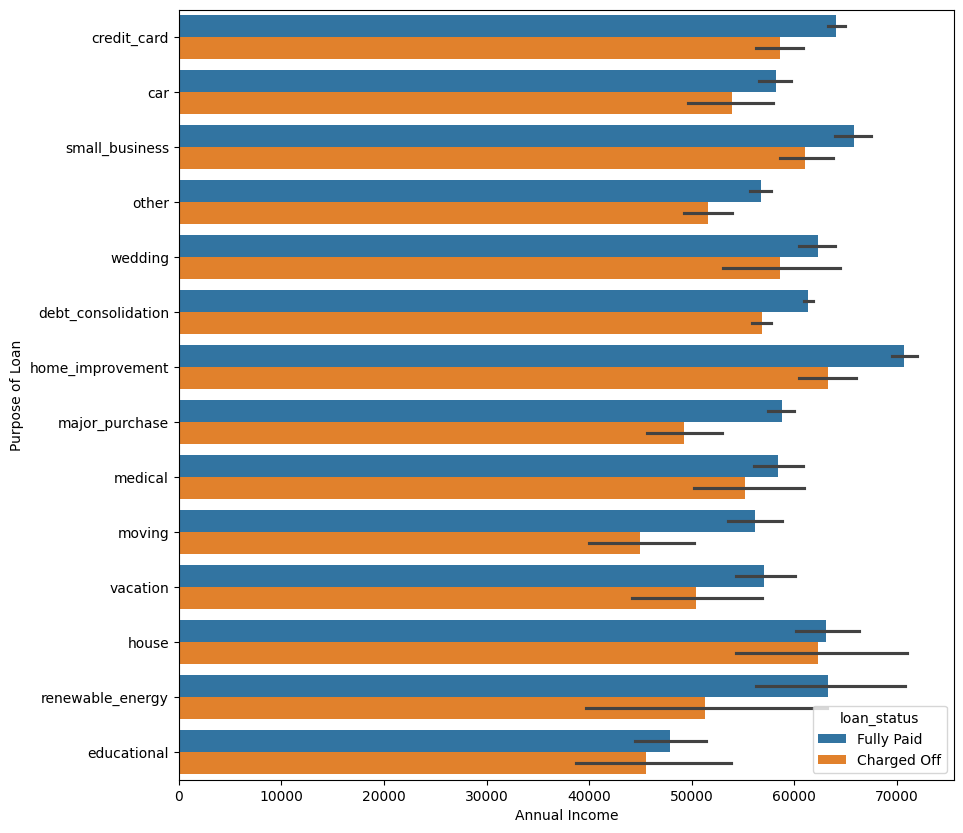

In [95]:
plt.figure(figsize=(10,10))
sns.barplot(data=loan_df, x='annual_inc', y='purpose', hue ='loan_status', palette="tab10")
plt.xlabel("Annual Income")
plt.ylabel("Purpose of Loan")
plt.show()

Though the number of loans applied and defaulted are the highest in number for "debt_consolation", the annual income of those who applied isn't the highest. 
- Applicants with higher salary mostly applied loans for "home_improvment", "house", "renewable_energy" and "small_businesses"

2. Annual income vs home ownership

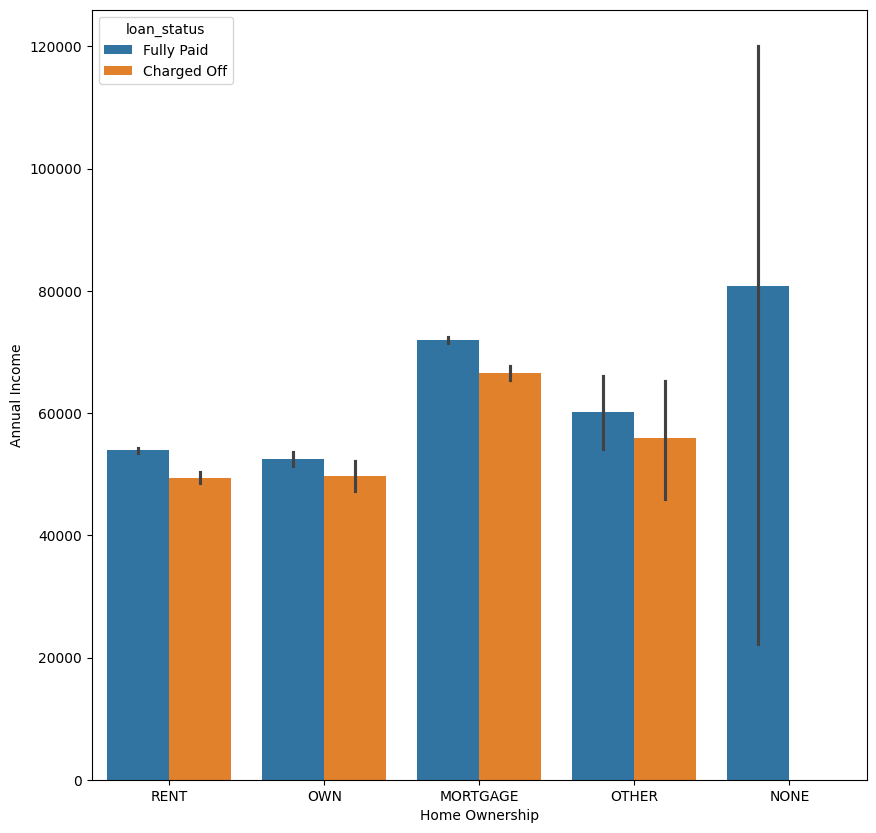

In [92]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_df,x='home_ownership', y='annual_inc', hue ='loan_status',palette="tab10")
plt.xlabel("Home Ownership")
plt.ylabel("Annual Income")
plt.show()

3. Annual Income vs Loan amount

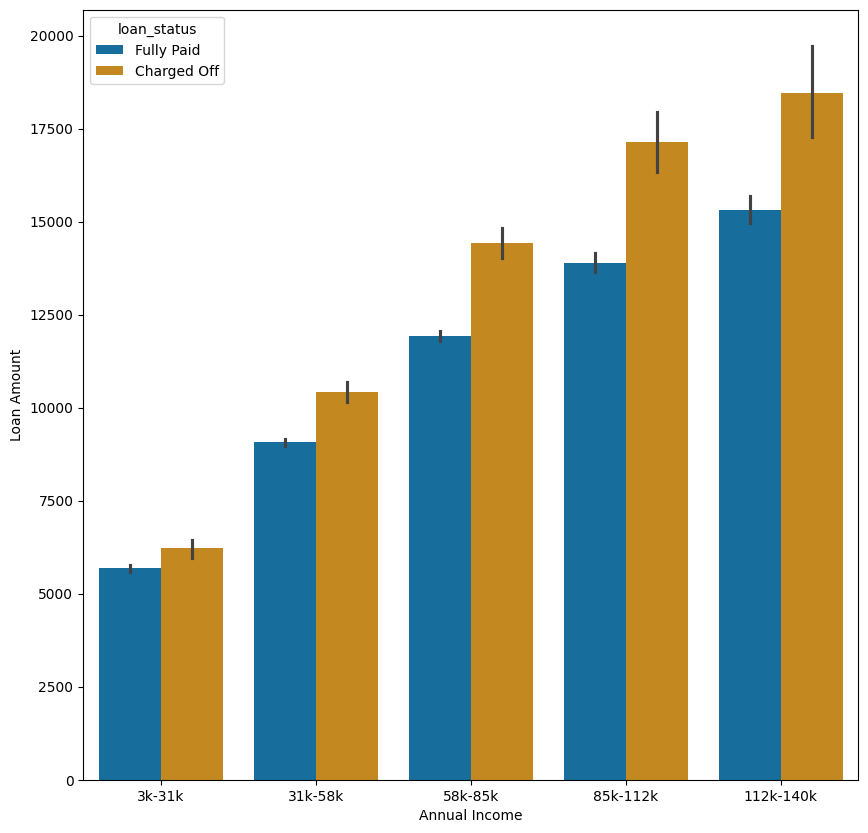

In [93]:
plt.figure(figsize=(10,10))
sns.barplot(x = "annual_inc_groups", y = "loan_amnt", hue = 'loan_status', data = loan_df)
plt.xlabel("Annual Income")
plt.ylabel("Loan Amount")
plt.show()

##### Across all the income groups, the loan_amount is higher for people who defaulted.

4. Annual income vs int_rate

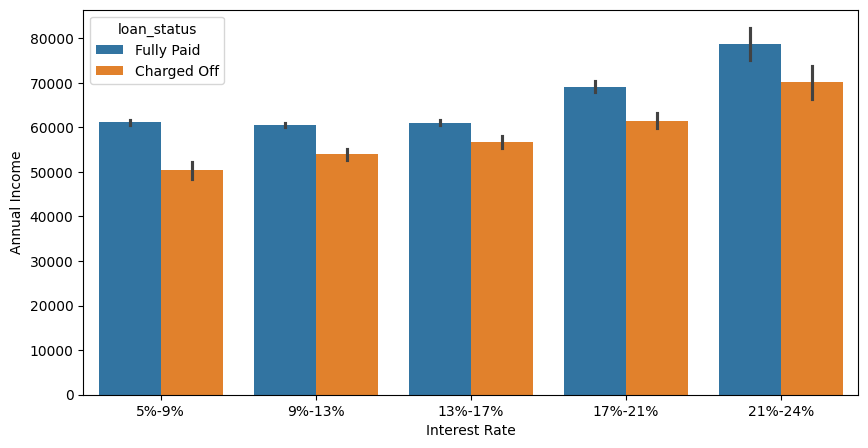

In [94]:
plt.figure(figsize=(10,5))
sns.barplot(data =loan_df,x='int_rate_groups', y='annual_inc', hue ='loan_status',palette="tab10")
plt.xlabel("Interest Rate")
plt.ylabel("Annual Income")
plt.show()

Observations on Annual Income

- Applicants of all the Annual Income groups have "Charged Off" more than "Fully Paid" for all the Loan Amounts.
- Applicants taking loan for 'Home Improvement' and have income of 60k -70k.
- Applicants whose home ownership is 'MORTGAGE and have income of 60-70k. But in all the Home Ownership categories we can find "Fully Paid" customers are more than "Charged Off".
- Applicants who receive interest at the rate of "21-24%" and have an income of 70k-80k.

Analysing "loan amount" with other columns for more insights 

1. Loan Amount vs Interest Rate

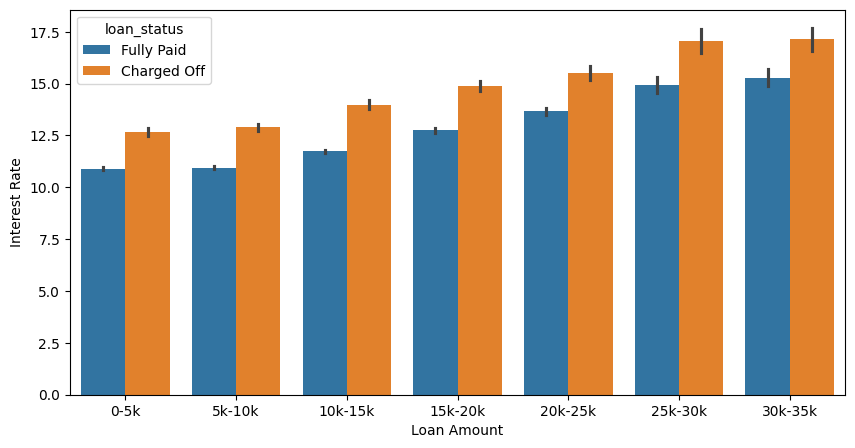

In [96]:
plt.figure(figsize=(10,5))
sns.barplot(data =loan_df,x='loan_amnt_groups', y='int_rate', hue ='loan_status',palette="tab10")
plt.xlabel("Loan Amount")
plt.ylabel("Interest Rate")
plt.show()

2. Loan Amount vs Loan purpose

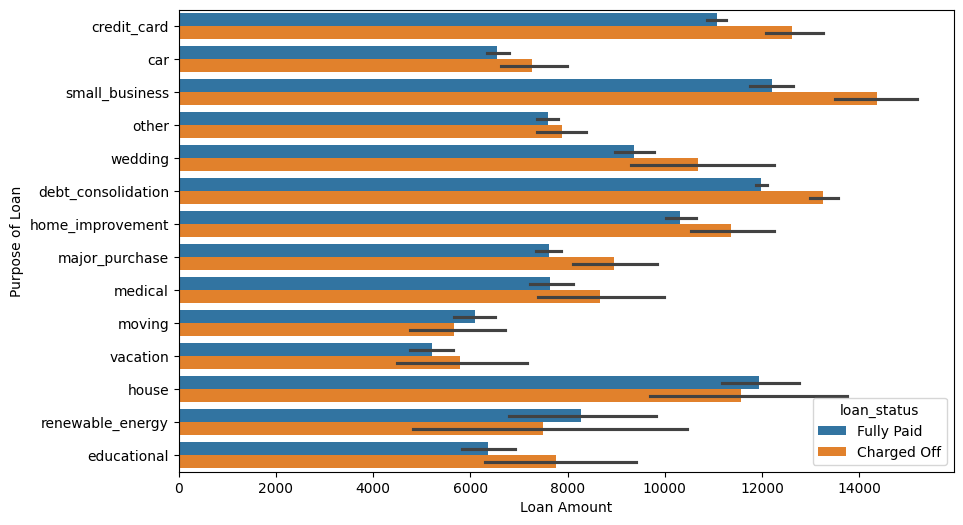

In [97]:
plt.figure(figsize=(10,6))
sns.barplot(data =loan_df,x='loan_amnt', y='purpose', hue ='loan_status',palette="tab10")
plt.xlabel("Loan Amount")
plt.ylabel("Purpose of Loan")
plt.show()

3. Loan Amount vs House Ownership

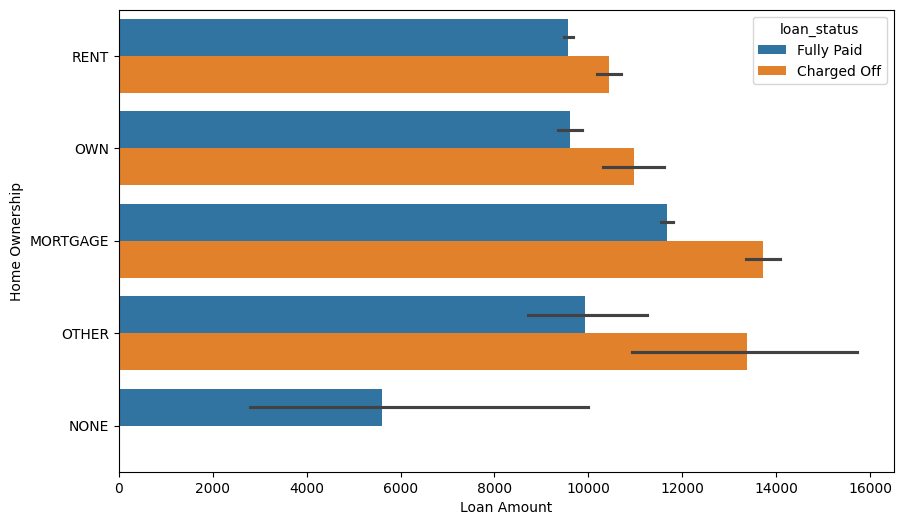

In [98]:
plt.figure(figsize=(10,6))
sns.barplot(data =loan_df,x='loan_amnt', y='home_ownership', hue ='loan_status',palette="tab10")
plt.xlabel("Loan Amount")
plt.ylabel("Home Ownership")
plt.show()

4. Loan Amount vs Issue Month & Issue Year

Text(0, 0.5, 'Loan Amount')

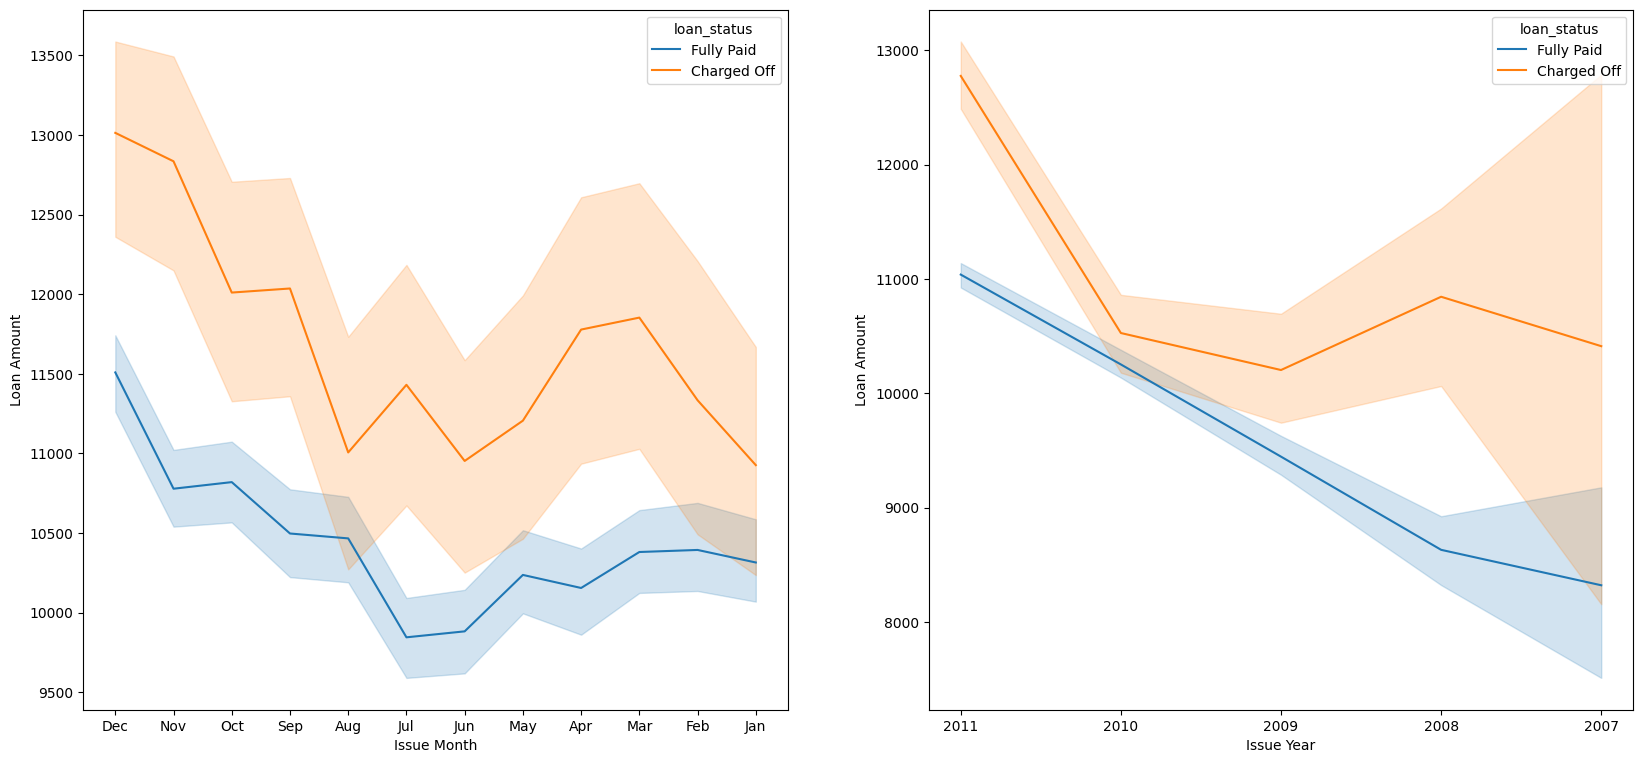

In [103]:
plt.figure(figsize=(20,20))
plt.subplot(221)
sns.lineplot(data =loan_df,y='loan_amnt', x='issue_month', hue ='loan_status',palette="tab10")
plt.xlabel("Issue Month")
plt.ylabel("Loan Amount")
plt.subplot(222)
sns.lineplot(data =loan_df,y='loan_amnt', x='issue_year', hue ='loan_status',palette="tab10")
plt.xlabel("Issue Year")
plt.ylabel("Loan Amount")

5. Loan Amount vs Grade

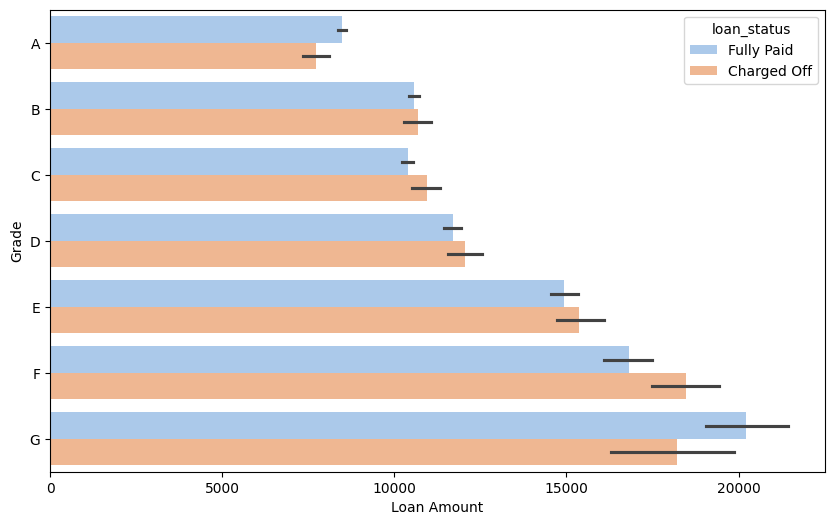

In [100]:
plt.figure(figsize=(10,6))
sns.barplot(data =loan_df,x='loan_amnt', y='grade', hue ='loan_status',palette="pastel", order=['A','B','C','D','E','F','G'])
plt.xlabel("Loan Amount")
plt.ylabel("Grade")
plt.show()

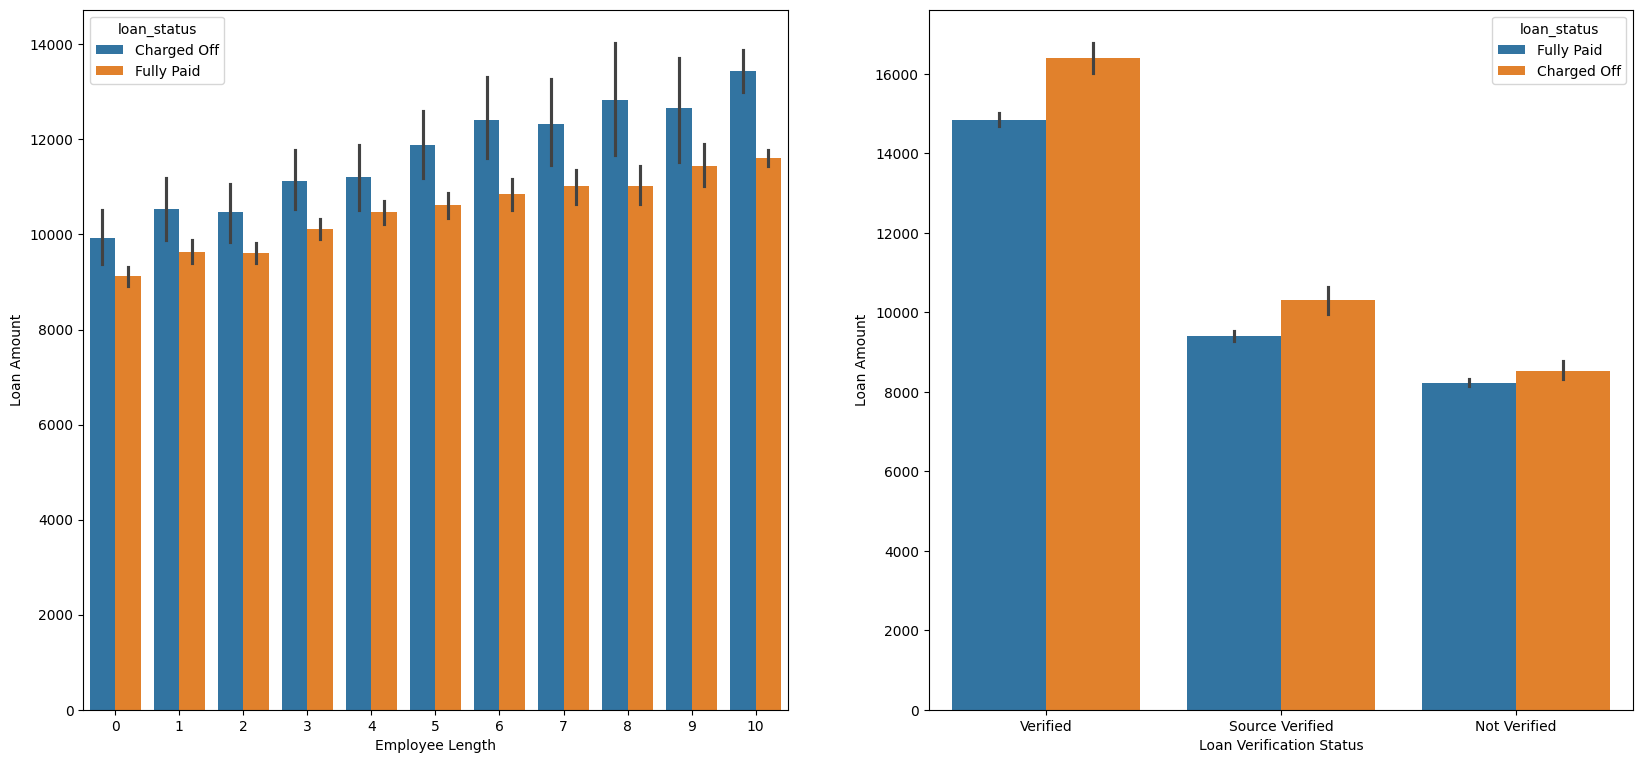

In [102]:
plt.figure(figsize=(20,20))
plt.subplot(221)
sns.barplot(data =loan_df,y='loan_amnt', x='emp_length', hue ='loan_status',palette="tab10")
plt.xlabel("Employee Length")
plt.ylabel("Loan Amount")
plt.subplot(222)
sns.barplot(data =loan_df,y='loan_amnt', x='verification_status', hue ='loan_status',palette="tab10")
plt.xlabel("Loan Verification Status")
plt.ylabel("Loan Amount")
plt.show()

Observations on Loan Amount

- For all the Interest Rates, Home Ownership categories, the probability of more Loan Amounts getting "Charged Off" is more than "Fully Paid".
- In Debt Consolidation, Small Business & Credit Card, probability of Loan Amounts getting "Charged Off" is more.
- For all the Employee Lengths the probability of Loan amounts getting "Charged Off" is less than "Fully Paid".
- Irrespective of Verification Status, the Loan amount gets "Charged Off" when compared to "Fully Paid".
- For Grade A & G, "Fully Paid" Loan Amounts are more than "Charged Off" Loan Amounts. For Other Grades (B, C, D, E, F) it is otherwise.
- In all the months & years, the "Charged Off" Loan Amounts are more than "Fully Paid".